In [85]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## data set の読み込み
- remote から取得する


In [86]:
!if [ -n akb.zip ]; then wget https://kokoichi0206.mydns.jp/data/saka/akb.zip; fi

In [87]:
!if [ -n saka.zip ]; then wget https://kokoichi0206.mydns.jp/data/saka/saka.zip; fi

In [88]:
!if [ -n akb.zip ]; then yes | unzip akb.zip >/dev/null; fi
!if [ -n akb.zip ]; then yes | unzip saka.zip >/dev/null; fi

In [89]:
!ls

akb  akb.zip  checkpoint_filepath.keras  drive	ml  saka  saka.zip  sample_data


In [90]:
import glob
import gc
import numpy as np
import os
from PIL import Image
from sklearn.model_selection import train_test_split
import tensorflow as tf
import tensorflow.keras.layers as layers


In [91]:
groups = ["akb", "saka"]

akbs = glob.glob("akb/*/*.jpg")
sakas = glob.glob("saka/*/*.jpg")
faces = []

print(np.asarray(Image.open(akbs[0]), np.uint8).shape)


for path in akbs:
    with Image.open(path) as img:
        # colabでリサイズする場合
        img = img.resize((64, 64), Image.LANCZOS)
        faces.append(np.asarray(img, np.uint8))

for path in sakas:
    with Image.open(path) as img:
        img = img.resize((64, 64), Image.LANCZOS)
        faces.append(np.asarray(img, np.uint8))

X = np.array(faces)
# 正解ラベルを作成する
len_akbs = len(akbs)
len_sakas = len(sakas)
a = np.zeros((len_akbs, 1), dtype="float32")
s = np.ones((len_sakas, 1), dtype="float32")
y = np.concatenate([a, s])

(512, 512, 3)


In [92]:
print(type(X))
print(type(y))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [93]:
print(X.shape)
print(y.shape)
print(X.shape[1])

(10193, 64, 64, 3)
(10193, 1)
64


## model の作成・訓練

In [94]:
# model と weight をローカルに保存するための準備
version = "5th"
f_log = "./log"
f_models = "/content/drive/MyDrive/Colab Notebooks/akimoto/models"
model_filename = f"model_{version}.json"
weight_filename = f"weights_{version}.hdf5"

In [95]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.05),
    ]
)

In [96]:
IMG_SIZE = X.shape[1]
inputs = layers.Input((IMG_SIZE, IMG_SIZE, 3))
x = data_augmentation(inputs)
## １層目
x = layers.Conv2D(64, 3, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)
x = layers.Conv2D(64, 3, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)
x = layers.AveragePooling2D(2)(x)
## 2層目
x = layers.Conv2D(128, 3, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)
x = layers.Conv2D(128, 3, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)
x = layers.AveragePooling2D(2)(x)
x = layers.Dropout(0.25)(x) # 追加
## 3層目
x = layers.Conv2D(256, 3, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)
x = layers.Conv2D(256, 3, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)
x = layers.AveragePooling2D(2)(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x) # 追加

# # ## 4層目
# x = layers.Conv2D(512, 3, padding="same")(x)
# x = layers.BatchNormalization()(x)
# x = layers.ReLU()(x)

# x = layers.GlobalAveragePooling2D()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)

model = keras.models.Model(inputs=inputs, outputs=outputs)
model.summary()

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 64, 64, 3)]       0         
                                                                 
 sequential_2 (Sequential)   (None, 64, 64, 3)         0         
                                                                 
 conv2d_57 (Conv2D)          (None, 64, 64, 64)        1792      
                                                                 
 batch_normalization_56 (Bat  (None, 64, 64, 64)       256       
 chNormalization)                                                
                                                                 
 re_lu_56 (ReLU)             (None, 64, 64, 64)        0         
                                                                 
 conv2d_58 (Conv2D)          (None, 64, 64, 64)        36928     
                                                           

In [97]:
json_string = model.to_json()
with open(os.path.join(f_models, model_filename), mode='w') as f:
    f.write(json_string)

In [98]:
def create_dataset(X, y, test_size=0.1, val_size=0.2, random_state=123):

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=round(val_size/(1-test_size), 2), random_state=random_state)

    return X_train.astype(np.float32) / 255.0, X_test.astype(np.float32) / 255.0, X_val.astype(np.float32) / 255.0, \
            y_train.astype(np.float32), y_test.astype(np.float32), y_val.astype(np.float32)

In [99]:
import tensorflow.keras as keras

model.compile(optimizer="rmsprop", loss='binary_crossentropy', metrics=['accuracy'])

batch_size = 32
epochs = 150

X_train, X_test, X_val, y_train, y_test, y_val = create_dataset(X, y)

checkpoint_filepath = "checkpoint_filepath.keras"

callbacks = [
    keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath,
                                    save_best_only=True,
                                    monitor="val_loss")
]

history = model.fit(X_train, y_train,
                    epochs=epochs,
                    validation_data=(X_val, y_val),
                    batch_size=batch_size,
                    callbacks=callbacks)

model.save_weights(os.path.join(f_models, weight_filename))


Epoch 1/150
224/224 [==============================] - 10s 35ms/step - loss: 1.0603 - accuracy: 0.5558 - val_loss: 0.7100 - val_accuracy: 0.5404
Epoch 2/150
224/224 [==============================] - 8s 35ms/step - loss: 0.7954 - accuracy: 0.5994 - val_loss: 0.6670 - val_accuracy: 0.6072
Epoch 3/150
224/224 [==============================] - 7s 33ms/step - loss: 0.7346 - accuracy: 0.6185 - val_loss: 0.6930 - val_accuracy: 0.6186
Epoch 4/150
224/224 [==============================] - 8s 34ms/step - loss: 0.6907 - accuracy: 0.6299 - val_loss: 0.8709 - val_accuracy: 0.5428
Epoch 5/150
224/224 [==============================] - 8s 34ms/step - loss: 0.6492 - accuracy: 0.6489 - val_loss: 1.0693 - val_accuracy: 0.5721
Epoch 6/150
224/224 [==============================] - 8s 34ms/step - loss: 0.6377 - accuracy: 0.6567 - val_loss: 0.6456 - val_accuracy: 0.6320
Epoch 7/150
224/224 [==============================] - 7s 33ms/step - loss: 0.6181 - accuracy: 0.6652 - val_loss: 0.7523 - val_accuracy

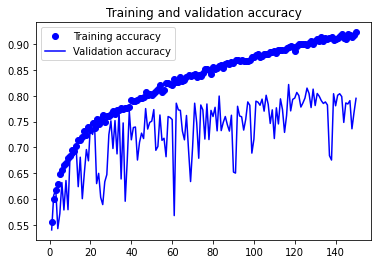

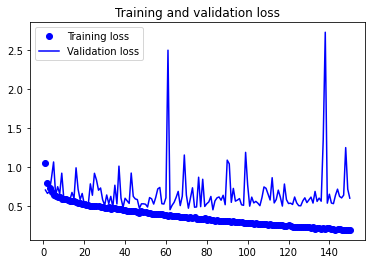

In [100]:
import matplotlib.pyplot as plt

acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()

plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()

plt.show()

In [101]:
test_model = keras.models.load_model(checkpoint_filepath)
test_loss, test_acc = test_model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_acc:.3f}")

32/32 [==============================] - 1s 11ms/step - loss: 0.4182 - accuracy: 0.8157
Test accuracy: 0.816
